In [89]:
import pandas as pd
import numpy as np

# data
import statsmodels.api as sm

# train-test split
from sklearn.cross_validation import train_test_split

# models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from functools import partial 

# performance metrics
from sklearn.metrics import roc_curve, auc, f1_score, average_precision_score, r2_score
from sklearn.metrics import confusion_matrix

# viz
from pandas.tools.plotting import scatter_matrix
%matplotlib inline

## Data source and notes

In [2]:
print(sm.datasets.fair.SOURCE)


Fair, Ray. 1978. "A Theory of Extramarital Affairs," `Journal of Political
    Economy`, February, 45-61.

The data is available at http://fairmodel.econ.yale.edu/rayfair/pdf/2011b.htm



In [3]:
print( sm.datasets.fair.NOTE)

::

    Number of observations: 6366
    Number of variables: 9
    Variable name definitions:

        rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                        4 = good, 5 = very good
        age             : Age
        yrs_married     : No. years married. Interval approximations. See
                        original paper for detailed explanation.
        children        : No. children
        religious       : How relgious, 1 = not, 2 = mildly, 3 = fairly,
                        4 = strongly
        educ            : Level of education, 9 = grade school, 12 = high
                        school, 14 = some college, 16 = college graduate,
                        17 = some graduate school, 20 = advanced degree
        occupation      : 1 = student, 2 = farming, agriculture; semi-skilled,
                        or unskilled worker; 3 = white-colloar; 4 = teacher
                        counselor social worker, nurse; artist, writers;
          

## Read and prepare data

In [94]:
df = pd.DataFrame(sm.datasets.fair.load().data)
df.head(5)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


The 'affairs' column is a 'measure of time spent in extramarital affairs' ([source](http://statsmodels.sourceforge.net/0.6.0/datasets/generated/fair.html)).

We convert this to a boolean: was there an affair or not?

In [95]:
df['affairs'] = (df.affairs > 0).astype(int)

In [96]:
df.head(1)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1


In [97]:
df["marriage_age_ratio"] = df.yrs_married/df.age
df["marriage_children_ratio"] = df.children/df.yrs_married

And finally, convert categorical variables into dummy variables:

In [98]:
df = pd.concat([
        df, 
        pd.get_dummies(df.occupation, prefix = 'occupation'), 
        pd.get_dummies(df.occupation_husb, prefix = 'occupation_husb')
    ], axis=1)
df.drop(['occupation', 'occupation_husb'], inplace = True, axis = 1)

## Train/test split

In [99]:
use_these   = [col for col in df.columns if col != 'affairs']
column_to_predict = 'affairs'
train_size = .75
test_size  = 1 - train_size

tr1, te1 = train_test_split(df[df.affairs == 1], train_size = train_size, test_size = test_size)
tr0, te0 = train_test_split(df[df.affairs == 0], train_size = train_size, test_size = test_size)

train = pd.concat([tr1, tr0], axis=0)
test  = pd.concat([te1, te0], axis=0)

Xtest = test[use_these]
ytest = test[column_to_predict].values

X = train[use_these]
y = train[column_to_predict].values

## Classify

In [100]:
clf = RandomForestClassifier(
            n_estimators = 1000,
            max_depth    = 9
)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [101]:
ypred = clf.predict(Xtest)

In [102]:
f1          = f1_score(ytest, ypred)
print 'f1:', f1

fpr, tpr, _ = roc_curve(ytest, ypred)
auc_roc     = auc(fpr, tpr)
print 'auc roc:', auc_roc

auc_pr      = average_precision_score(ytest, ypred)
print 'auc pr:', auc_pr

print 'confusion matrix:'
print np.array(confusion_matrix(ypred, ytest))

f1: 0.448407643312
auc roc: 0.627183982864
auc pr: 0.602018612901
confusion matrix:
[[984 338]
 [ 95 176]]


## Hyperopt: Random Forest

In [103]:
space = {
            "n_estimators" :      hp.quniform("n_estimators", 100, 800, 50),
            "criterion":          hp.choice("criterion", ['gini', 'entropy']),
            "max_depth":          hp.quniform("max_depth", 2, 20, 1),
            "max_leaf_nodes":     hp.quniform("max_leaf_nodes", 2, 100, 1),
            "min_samples_split":  hp.quniform("min_samples_split", 10, 500, 10),
            "min_weight_fraction_leaf": hp.quniform("min_weight_fraction_leaf", .1, 0.5, .05),
            "max_features":       hp.quniform("max_features", 0.1, 1, .1)
          }

In [104]:
def FitModelAndComputeMetrics(X, y, Xtest, ytest, parameters):
#    print 'Trying the following model:'
#    print '\t', parameters
    
    # Fit the model:
    fitted_model = RandomForestClassifier(n_estimators          = int(parameters['n_estimators']),
                                            criterion           = parameters['criterion'],
                                            max_depth           = int(parameters['max_depth']),
                                            min_samples_split   = int(parameters['min_samples_split']),
                                            min_weight_fraction_leaf = parameters['min_weight_fraction_leaf'],
                                            max_features        = parameters['max_features'],
                                            max_leaf_nodes      = int(parameters['max_leaf_nodes']),
                                            # set the number of jobs to the number of cores.
                                            n_jobs              = -1
                    )

    fitted_model.fit(X,y)
    # Make predictions:
    ypred = fitted_model.predict(Xtest)
    
    # Compute metric
    fpr, tpr, _ = roc_curve(ytest, ypred)
    auc_roc     = auc(fpr, tpr)
    #print 'auc roc:', auc_roc

    # And return the auc roc - this is what we want to optimize
    return auc_roc

In [106]:
trials = Trials()

best = fmin(
                lambda parameters: -FitModelAndComputeMetrics(X, y, Xtest, ytest, parameters),
                space     = space,
                algo      = partial(tpe.suggest, n_startup_jobs=10),# seed=1233,,
                max_evals = 500,
                trials    = trials
        )

### Look at the 'winning' model:

In [107]:
best

{'criterion': 1,
 'max_depth': 7.0,
 'max_features': 0.8,
 'max_leaf_nodes': 78.0,
 'min_samples_split': 290.0,
 'min_weight_fraction_leaf': 0.15000000000000002,
 'n_estimators': 550.0}

In [110]:
clf = RandomForestClassifier(
            criterion                = ['gini', 'entropy'][best['criterion']],
            n_estimators             = int(best['n_estimators']),
            max_depth                = int(best['max_depth']),
            max_features             = best['max_features'],
            min_samples_split        = int(best['min_samples_split']),
            min_weight_fraction_leaf = int(best['min_weight_fraction_leaf'])
)
clf.fit(X, y)
ypred = clf.predict(Xtest)

In [111]:
f1          = f1_score(ytest, ypred)
print 'f1:', f1

fpr, tpr, _ = roc_curve(ytest, ypred)
auc_roc     = auc(fpr, tpr)
print 'auc roc:', auc_roc

auc_pr      = average_precision_score(ytest, ypred)
print 'auc pr:', auc_pr

print 'confusion matrix:'
print np.array(confusion_matrix(ypred, ytest))

f1: 0.480916030534
auc roc: 0.645390601616
auc pr: 0.633287399116
confusion matrix:
[[996 325]
 [ 83 189]]


### Visualize search space:

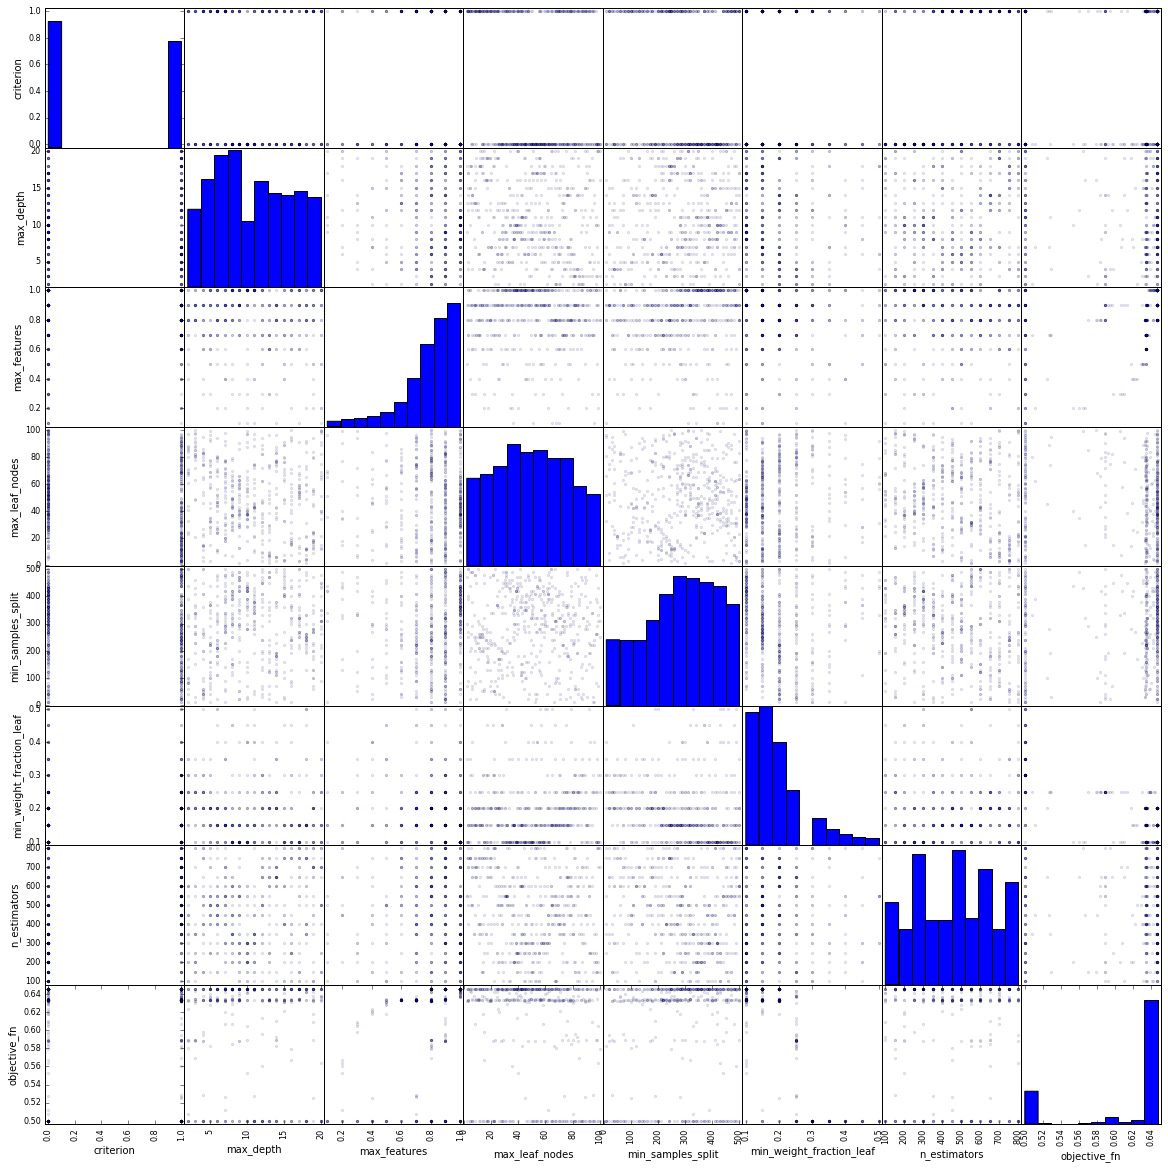

In [112]:
trials_df = pd.DataFrame(trials.vals)
trials_df["objective_fn"] = [-x for x in trials.losses()]
scatter_matrix(trials_df, alpha=0.1, figsize=(20, 20), diagonal='hist');

## Example 2: model type as hyperparameter

In [113]:
space = hp.choice("model_class",
                  [
                    {
                        "model_type":          'RF',
                         "n_estimators":       hp.quniform("n_estimators_rf", 100, 800, 50),
                         "criterion":          hp.choice("criterion_rf", ['gini', 'entropy']),
                         "max_depth":          hp.quniform("max_depth_rf", 2, 20, 1),
                         "max_leaf_nodes":     hp.quniform("max_leaf_nodes_rf", 2, 100, 1),
                         "min_samples_split":  hp.quniform("min_samples_split_rf", 10, 500, 10),
                         "min_weight_fraction_leaf": hp.quniform("min_weight_fraction_leaf_rf", .1, 0.5, .05),
                         "max_features":       hp.quniform("max_features_rf", 0.1, 1, .1)
                     },
                    {
                        "model_type":          'XGB',
                        'eta':                 hp.quniform("eta_xgb", 0, 1, .05), 
                        'max_depth':           hp.quniform("max_depth_xgb", 2, 10, 1),
                        'min_child_weight':    hp.quniform("min_child_weight_xgb", 10, 100, 10),
                        'max_delta_step':      hp.quniform("max_delta_step_xgb", 1, 10, 1),
                        'subsample':           hp.quniform("subsample_xgb", 0.05, 1, .05),
                        'colsample_bytree':    hp.quniform("colsample_bytree_xgb", 0.05, 1, .05),
                        'num_boost_round':     hp.quniform("num_boost_round_xgb", 100, 1000, 50)
                    }
        ]
)

In [116]:
def FitModelAndComputeMetric2(X, y, Xtest, ytest, parameters):
    if parameters['model_type'] == 'RF':
        fitted_model = RandomForestClassifier(n_estimators          = int(parameters['n_estimators']),
                                                criterion           = parameters['criterion'],
                                                max_depth           = int(parameters['max_depth']),
                                                min_samples_split   = int(parameters['min_samples_split']),
                                                min_weight_fraction_leaf = parameters['min_weight_fraction_leaf'],
                                                max_features        = parameters['max_features'],
                                                max_leaf_nodes      = int(parameters['max_leaf_nodes']),
                                                # set the number of jobs to the number of cores.
                                                n_jobs              = -1
                        )

        fitted_model.fit(X,y)
        ypred = fitted_model.predict(Xtest)
        
    else:
        dtrain = xgb.DMatrix(X, label = y, missing = float('NaN'))
        fitted_model = xgb.train(
                             parameters,
                             dtrain,
                             int(parameters['num_boost_round']),
                             [(dtrain, 'train')],
                             verbose_eval=100
                       )
        ypred = fitted_model.predict(xgb.DMatrix(Xtest, missing = float('NaN')))
  
    # Compute metric
    fpr, tpr, _ = roc_curve(ytest, ypred)
    auc_roc     = auc(fpr, tpr)
    #print 'auc roc:', auc_roc

    # And return the auc roc - this is what we want to optimize
    return auc_roc

In [117]:
trials = Trials()

best = fmin(
                lambda parameters: -FitModelAndComputeMetric2(X, y, Xtest, ytest, parameters),
                space     = space,
                algo      = partial(tpe.suggest, n_startup_jobs=10),
                max_evals = 1000,
                trials    = trials
        )

[0]	train-rmse:0.500000
[100]	train-rmse:0.500000
[200]	train-rmse:0.500000
[299]	train-rmse:0.500000
[0]	train-rmse:0.462078
[100]	train-rmse:0.428933
[200]	train-rmse:0.428379
[300]	train-rmse:0.426938
[400]	train-rmse:0.427286
[500]	train-rmse:0.427512
[600]	train-rmse:0.428755
[649]	train-rmse:0.429579
[0]	train-rmse:0.485002
[100]	train-rmse:0.420549
[200]	train-rmse:0.417852
[300]	train-rmse:0.416259
[400]	train-rmse:0.414546
[500]	train-rmse:0.413610
[600]	train-rmse:0.412451
[649]	train-rmse:0.411937
[0]	train-rmse:0.430630
[100]	train-rmse:0.359694
[200]	train-rmse:0.334045
[300]	train-rmse:0.317564
[399]	train-rmse:0.306492
[0]	train-rmse:0.438414
[100]	train-rmse:0.379200
[199]	train-rmse:0.360512
[0]	train-rmse:0.480063
[100]	train-rmse:0.429376
[200]	train-rmse:0.428142
[300]	train-rmse:0.428300
[400]	train-rmse:0.427338
[499]	train-rmse:0.427498
[0]	train-rmse:0.500000
[100]	train-rmse:0.500000
[200]	train-rmse:0.500000
[300]	train-rmse:0.500000
[400]	train-rmse:0.500000


### Look at 'best' model

In [119]:
best

{'colsample_bytree_xgb': 0.15000000000000002,
 'eta_xgb': 0.05,
 'max_delta_step_xgb': 2.0,
 'max_depth_xgb': 2.0,
 'min_child_weight_xgb': 30.0,
 'model_class': 1,
 'num_boost_round_xgb': 400.0,
 'subsample_xgb': 0.25}

In [122]:
dtrain = xgb.DMatrix(X, label = y, missing = float('NaN'))
fitted_model = xgb.train(
                             {x.replace('_xgb', ''):y for x,y in best.iteritems()},
                             dtrain,
                             int(best['num_boost_round_xgb']),
                             [(dtrain, 'train')],
                             verbose_eval=100
                       )
ypred = fitted_model.predict(xgb.DMatrix(Xtest, missing = float('NaN')))>.5

[0]	train-rmse:0.495516
[100]	train-rmse:0.433924
[200]	train-rmse:0.426320
[300]	train-rmse:0.424574
[399]	train-rmse:0.423584


In [123]:
f1          = f1_score(ytest, ypred)
print 'f1:', f1

fpr, tpr, _ = roc_curve(ytest, ypred)
auc_roc     = auc(fpr, tpr)
print 'auc roc:', auc_roc

auc_pr      = average_precision_score(ytest, ypred)
print 'auc pr:', auc_pr

print 'confusion matrix:'
print np.array(confusion_matrix(ypred, ytest))

f1: 0.476433121019
auc roc: 0.642981684295
auc pr: 0.62956159981
confusion matrix:
[[995 327]
 [ 84 187]]


### Visualize search space

First, we disentangle results. Split all results into RF results and XGB results:

In [124]:
rf_keys  = [x.replace("_rf", "") for x in trials.vals.keys() if 'rf' in x]
xgb_keys = [x.replace("_xgb", "") for x in trials.vals.keys() if 'xgb' in x]

results_with_model_type = zip(['rf' if x == 0 else 'xgb' for x in trials.vals['model_class']], [-x['loss'] for x in trials.results])

In [125]:
rf_dict = {k:v for k,v in trials.vals.iteritems() if k.replace("_rf", "") in rf_keys}
rf_dict['score'] = [x[1] for x in results_with_model_type if x[0] == 'rf']

xgb_dict = {k:v for k,v in trials.vals.iteritems() if k.replace("_xgb", "") in xgb_keys}
xgb_dict['score'] = [x[1] for x in results_with_model_type if x[0] == 'xgb']

And now we're ready to plot the data frames:

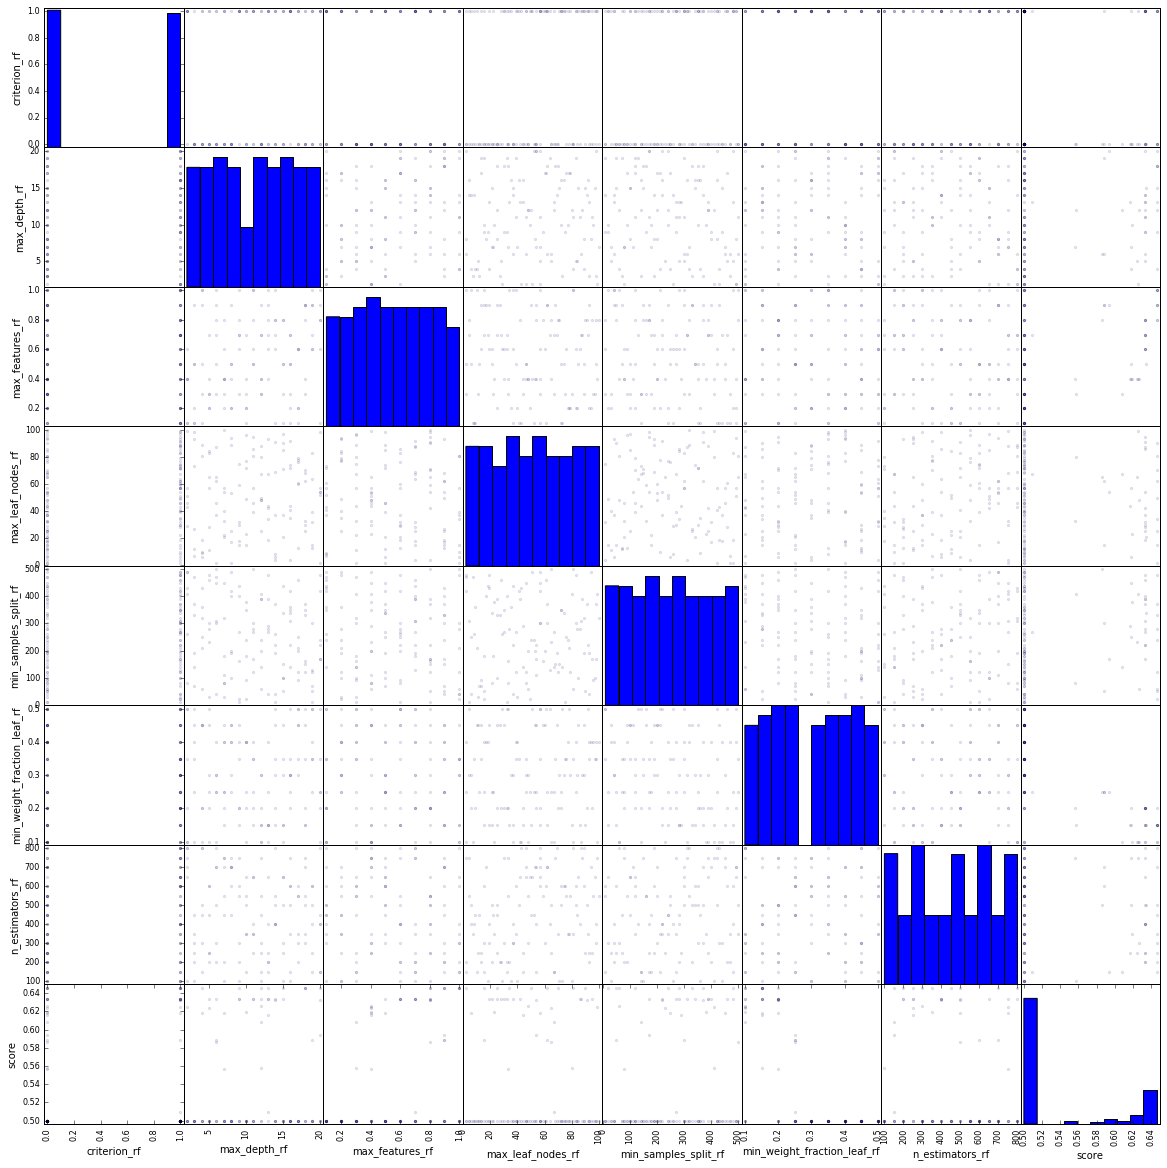

In [126]:
# RF
scatter_matrix(pd.DataFrame(rf_dict), alpha=0.1, figsize=(20, 20), diagonal='hist');

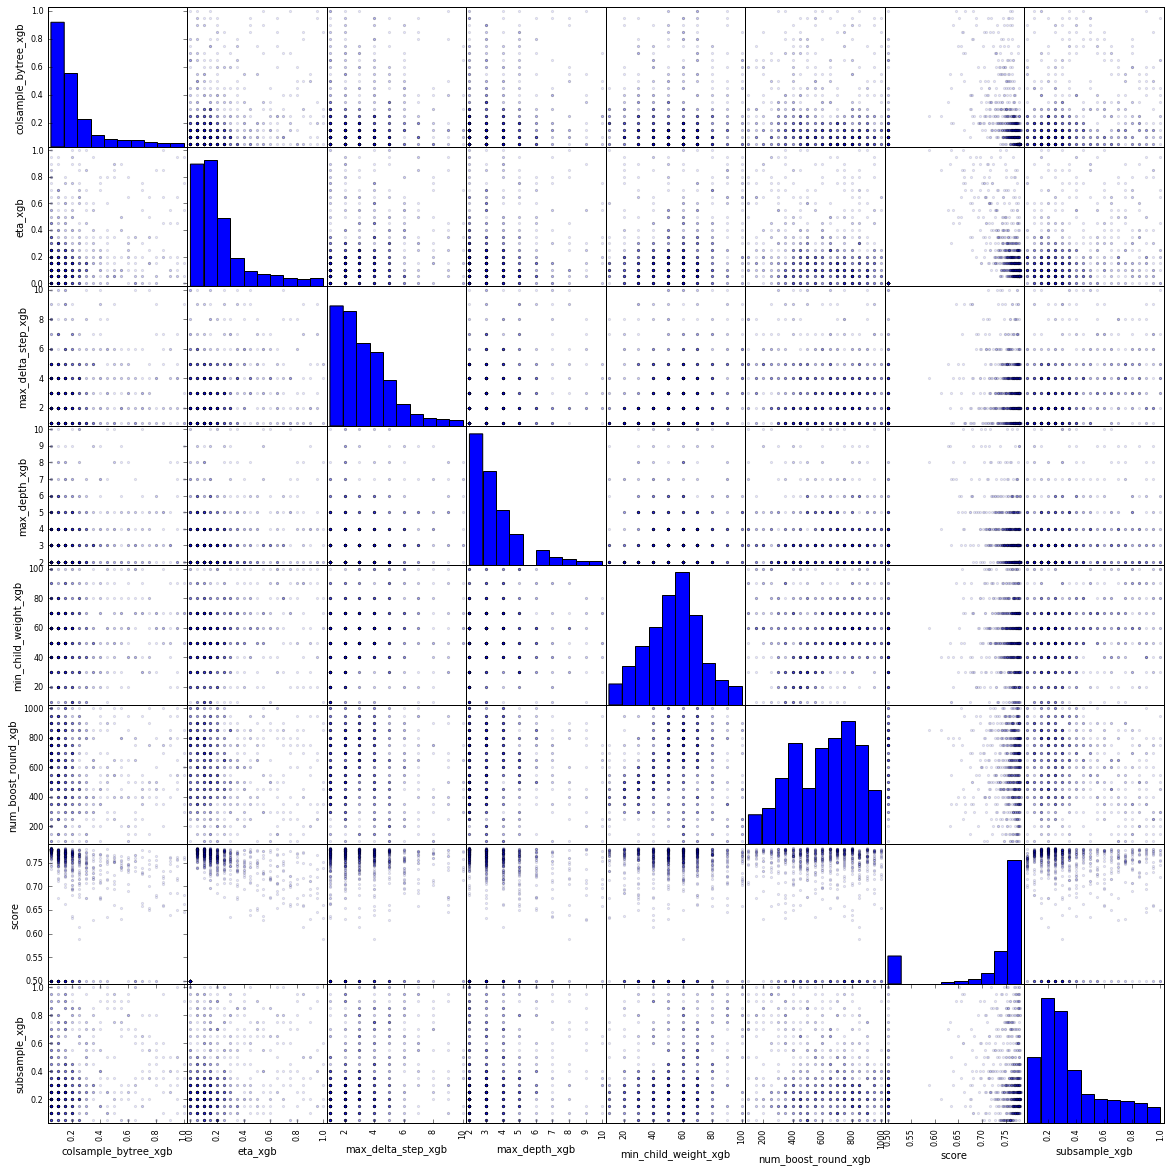

In [127]:
# XGB
scatter_matrix(pd.DataFrame(xgb_dict), alpha=0.1, figsize=(20, 20), diagonal='hist');